In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import DebertaTokenizer, TFDebertaForSequenceClassification, create_optimizer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

/Users/sankalpaswani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sankalpaswani/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Load and Prepare the Dataset

In [4]:
# Define column names for the dataset
# Example: First column is 'id', second is 'label', etc.
column_names = [
    'id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
    'state', 'party', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'
]

# Load the datasets from TSV files
# Example: Load "The president signed a new bill" as a row in train_df
train_df = pd.read_csv('liar_dataset (2)/train.tsv', sep='\t', names=column_names)
valid_df = pd.read_csv('liar_dataset (2)/valid.tsv', sep='\t', names=column_names)
test_df = pd.read_csv('liar_dataset (2)/test.tsv', sep='\t', names=column_names)

# Convert multi-class labels to binary (1 = true/mostly-true, 0 = everything else)
# Example: Convert "mostly-true" → 1, "half-true" → 0
def binarize_label(label):
    return 1 if label in ['true', 'mostly-true'] else 0

train_df['binary_label'] = train_df['label'].apply(binarize_label)
valid_df['binary_label'] = valid_df['label'].apply(binarize_label)
test_df['binary_label'] = test_df['label'].apply(binarize_label)

# Print dataset statistics
print(f"Training set: {len(train_df)} examples")
print(f"  - True claims: {sum(train_df['binary_label'])} ({sum(train_df['binary_label'])/len(train_df)*100:.1f}%)")
print(f"  - False claims: {len(train_df) - sum(train_df['binary_label'])} ({(1-sum(train_df['binary_label'])/len(train_df))*100:.1f}%)")
print(f"Validation set: {len(valid_df)} examples")
print(f"Test set: {len(test_df)} examples")

# Display sample claims
print("\nSample claims from training set:")
for i, row in train_df.sample(3).iterrows():
    print(f"Statement: {row['statement']}")
    print(f"Label: {row['label']} (Binary: {row['binary_label']})")
    print("---")

Training set: 10240 examples
  - True claims: 3638 (35.5%)
  - False claims: 6602 (64.5%)
Validation set: 1284 examples
Test set: 1267 examples

Sample claims from training set:
Statement: Polling shows that nearly 74 percent of National Rifle Association members support requiring background checks for all gun sales.
Label: true (Binary: 1)
---
Statement: I left the city with $43 million in the bank.
Label: barely-true (Binary: 0)
---
Statement: Says she couldn't take stimulus money because it required "universal building codes."
Label: false (Binary: 0)
---


## 2. Tokenize the Text Data


In [5]:
# Load the DeBERTa tokenizer
# Example: Loads the tokenizer that converts text to token IDs
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

# Define a function to tokenize the statements
# Example: Converts "The president signed a bill" → [101, 1996, 7351, 3000, 1037, 3857, 102]
def tokenize_statements(df, max_length=128):
    return tokenizer(
        list(df['statement']),  # Extract statements as a list
        padding='max_length',   # Add padding to make all sequences the same length
        truncation=True,        # Truncate sequences longer than max_length
        max_length=max_length,  # Set maximum sequence length
        return_tensors='tf'     # Return as TensorFlow tensors
    )

# Tokenize the datasets
# Example: Convert all statements to numerical token IDs
train_encodings = tokenize_statements(train_df)
valid_encodings = tokenize_statements(valid_df)
test_encodings = tokenize_statements(test_df)

# Extract labels as numpy arrays
y_train = train_df['binary_label'].values
y_valid = valid_df['binary_label'].values
y_test = test_df['binary_label'].values

# Show tokenization example
example_text = train_df['statement'].iloc[0]
example_tokens = tokenizer.tokenize(example_text)
example_ids = tokenizer.encode(example_text)

print(f"\nTokenization Example:")
print(f"Original text: {example_text}")
print(f"Tokenized: {example_tokens[:10]}... (total: {len(example_tokens)} tokens)")
print(f"Token IDs: {example_ids[:10]}... (total: {len(example_ids)} tokens)")


Tokenization Example:
Original text: Says the Annies List political group supports third-trimester abortions on demand.
Tokenized: ['S', 'ays', 'Ġthe', 'ĠAnn', 'ies', 'ĠList', 'Ġpolitical', 'Ġgroup', 'Ġsupports', 'Ġthird']... (total: 17 tokens)
Token IDs: [1, 104, 4113, 5, 3921, 918, 9527, 559, 333, 4548]... (total: 19 tokens)


## 3. Define Focal Loss Function

In [6]:
# Define focal loss to handle class imbalance
# Example: Gives more weight to hard-to-classify examples and minority class
def focal_loss(gamma=2.0, alpha=0.75):
    """
    Focal Loss: Focuses more on hard-to-classify examples
    gamma: Focusing parameter (higher gamma = more focus on hard examples)
    alpha: Class weight parameter (higher alpha = more weight to positive class)
    """
    def focal_loss_fn(y_true, y_pred):
        # Convert logits to probabilities
        y_pred = tf.nn.sigmoid(y_pred)
        
        # Convert labels to float32
        y_true = tf.cast(y_true, tf.float32)
        
        # Calculate the probability of the ground truth class
        # Example: If true label=1 and pred=0.8, pt=0.8; if true label=0 and pred=0.8, pt=0.2
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        
        # Apply class weighting
        # Example: If true label=1, weight by alpha; if true label=0, weight by (1-alpha)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # Apply focusing parameter
        # Example: For hard examples (pt close to 0), gives higher weight
        modulating_factor = tf.pow(1.0 - pt, gamma)
        
        # Calculate binary cross-entropy (standard loss)
        ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
        
        # Combine all factors to get focal loss
        loss = alpha_factor * modulating_factor * ce
        
        # Return mean loss across batch
        return tf.reduce_mean(loss)
    
    return focal_loss_fn

## 4. Set Training Parameters and Compute Class Weights

In [9]:
# Set training hyperparameters
batch_size = 16        # Process 16 examples at a time
epochs = 5             # Go through the data 5 times
max_length = 128       # Maximum sequence length
learning_rate = 2e-5   # Small learning rate for fine-tuning

# Calculate how many training steps we'll do
train_subset_size = min(8000, len(y_train))  # Use up to 8000 examples to save time
train_steps = train_subset_size // batch_size * epochs
warmup_steps = train_steps // 10  # Warm up for 10% of total steps

# Extract a subset of training data
x_train_ids = train_encodings['input_ids'][:train_subset_size]
x_train_mask = train_encodings['attention_mask'][:train_subset_size]
y_train_subset = y_train[:train_subset_size]

# Compute class weights to handle imbalance
# Example: If 70% are false and 30% are true, true claims get ~2.3x weight
labels = np.unique(y_train_subset)
class_weights = compute_class_weight('balanced', classes=labels, y=y_train_subset)
class_weights_dict = dict(zip(labels, class_weights))
print(f"\nClass weights: {class_weights_dict}")


Class weights: {np.int64(0): np.float64(0.778816199376947), np.int64(1): np.float64(1.3966480446927374)}


## 5. Create and Compile the Model

In [10]:
# Create optimizer with learning rate warmup
# Example: Start with small lr and gradually increase to specified lr
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=train_steps,
    num_warmup_steps=warmup_steps,
    weight_decay_rate=0.01
)

# Load the pre-trained DeBERTa model with classification head
# Example: Takes DeBERTa base and adds a layer for binary classification
model = TFDebertaForSequenceClassification.from_pretrained(
    'microsoft/deberta-base',  # Pre-trained model
    num_labels=1,             # Binary classification (single output node)
    hidden_dropout_prob=0.1,  # Dropout rate in transformer layers
    attention_probs_dropout_prob=0.1  # Dropout rate in attention layers
)

# Compile the model
# Example: Sets up how the model will train (loss function, optimizer, metrics)
model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2.0, alpha=0.75),  # Use focal loss with specified parameters
    metrics=['accuracy']  # Track accuracy during training
)

# Print model summary
print("\nModel Architecture:")
model.summary(line_length=100)

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler', 'classifier', 'cls_dropout']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Architecture:
Model: "tf_deberta_for_sequence_classification"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 deberta (TFDebertaMainLayer)                multiple                                138601728      
                                                                                                    
 pooler (TFDebertaContextPooler)             multiple                                590592         
                                                                                                    
 cls_dropout (TFDebertaStableDropout)        multiple                                0              
                                                                                                    
 classifier (Dense)                          multiple                                769            
                      

## 6. Train the Model with Early Stopping

In [13]:
# Set up early stopping and model checkpointing
# Example: Monitor val_loss, stop if no improvement for 2 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Set up model checkpoint to save best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'BEST_deberta_model',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Combine callbacks
callbacks = [early_stopping, model_checkpoint]

# Train the model
print("\nStarting model training...")
history = model.fit(
    [x_train_ids, x_train_mask],  # Input: token IDs and attention masks
    y_train_subset,              # Target: binary labels (0 or 1)
    validation_data=([valid_encodings['input_ids'], valid_encodings['attention_mask']], y_valid),
    epochs=epochs,               # Number of training epochs
    batch_size=batch_size,       # Batch size
    class_weight=class_weights_dict,  # Apply class weights
    callbacks=callbacks,         # Use callbacks for early stopping
    verbose=1                    # Show progress bar
)


Starting model training...
Epoch 1/5
500/500 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.6640
Epoch 1: val_loss improved from inf to 0.06987, saving model to BEST_deberta_model
INFO:tensorflow:Assets written to: BEST_deberta_model/assets


INFO:tensorflow:Assets written to: BEST_deberta_model/assets


500/500 [==============================] - 2615s 5s/step - loss: 0.0680 - accuracy: 0.6640 - val_loss: 0.0699 - val_accuracy: 0.6083
Epoch 2/5
500/500 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.6914 
Epoch 2: val_loss improved from 0.06987 to 0.06114, saving model to BEST_deberta_model
INFO:tensorflow:Assets written to: BEST_deberta_model/assets


INFO:tensorflow:Assets written to: BEST_deberta_model/assets


500/500 [==============================] - 5668s 11s/step - loss: 0.0608 - accuracy: 0.6914 - val_loss: 0.0611 - val_accuracy: 0.6760
Epoch 3/5
500/500 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.7589
Epoch 3: val_loss did not improve from 0.06114
500/500 [==============================] - 2836s 6s/step - loss: 0.0446 - accuracy: 0.7589 - val_loss: 0.0730 - val_accuracy: 0.6168
Epoch 4/5
500/500 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.8307
Epoch 4: val_loss did not improve from 0.06114
500/500 [==============================] - 5230s 10s/step - loss: 0.0270 - accuracy: 0.8307 - val_loss: 0.0795 - val_accuracy: 0.6581
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


## 7. Plot Training History

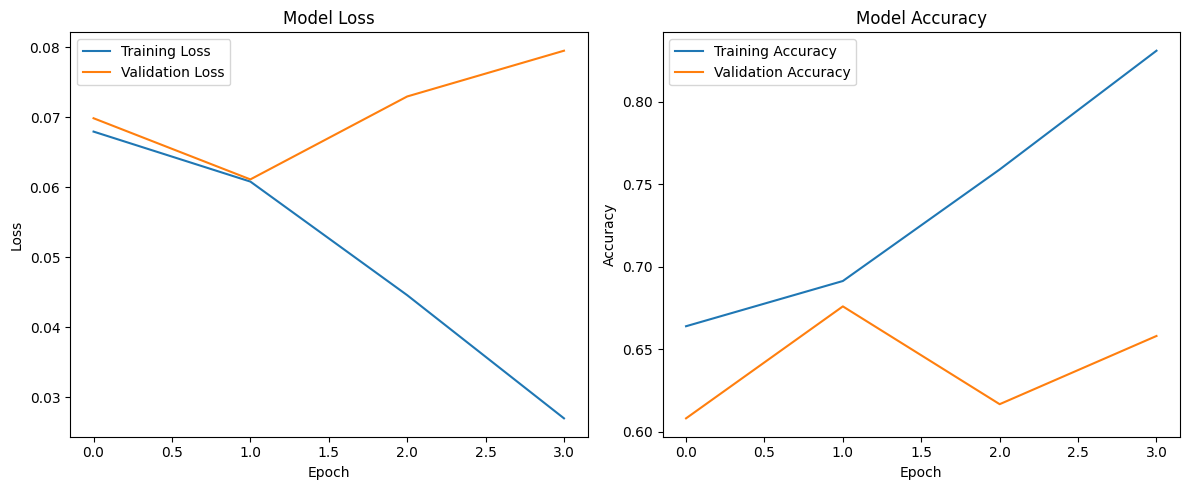

In [14]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('deberta_training_history.png', dpi=300)
plt.show()

## 8. Find Optimal Threshold on Validation Set


Optimal threshold: 0.4035 with F1 score: 0.5434


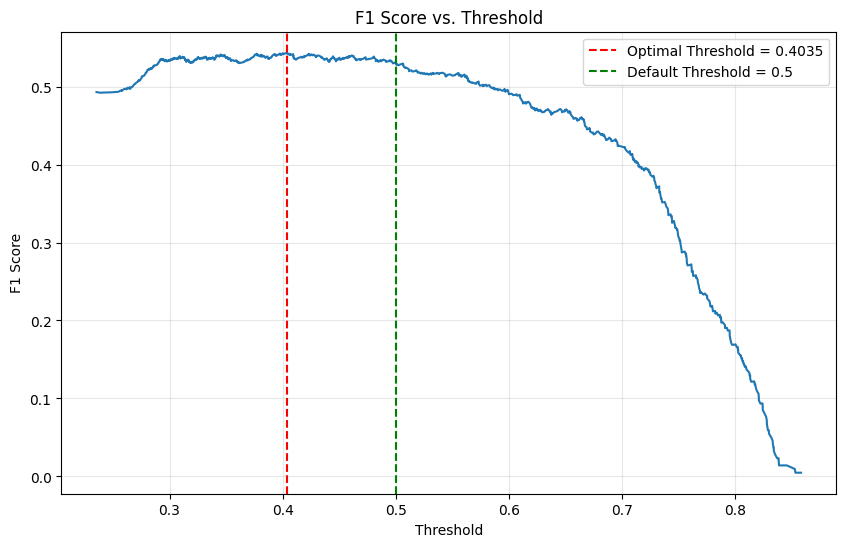

In [16]:
# Find optimal threshold by maximizing F1 score
from sklearn.metrics import precision_recall_curve, f1_score

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_valid, valid_probs)

# Calculate F1 score for each threshold
f1_scores = []
for i in range(len(thresholds)):
    # Use matching precision and recall values
    f1 = 2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i] + 1e-10)
    f1_scores.append(f1)

# Find threshold with best F1 score
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nOptimal threshold: {optimal_threshold:.4f} with F1 score: {best_f1:.4f}")

# Plot F1 score vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)  # Now these should be the same length
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.axvline(x=0.5, color='g', linestyle='--', 
            label='Default Threshold = 0.5')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('f1_vs_threshold.png', dpi=300)
plt.show()

## 9. Evaluate on Validation Set

In [18]:


# Evaluate with optimal threshold
# Example: Predict with threshold that maximizes F1 score
valid_preds_optimal = (valid_probs >= optimal_threshold).astype(int)
# Evaluate with default threshold
# Example: Predict with standard 0.5 threshold for comparison
valid_preds_default = (valid_probs >= 0.5).astype(int)

# Calculate metrics for optimal threshold
valid_accuracy_optimal = np.mean(valid_preds_optimal == y_valid)
valid_precision_optimal, valid_recall_optimal, valid_f1_optimal, _ = precision_recall_fscore_support(
    y_valid, valid_preds_optimal, average='binary'
)

# Calculate metrics for default threshold
valid_accuracy_default = np.mean(valid_preds_default == y_valid)
valid_precision_default, valid_recall_default, valid_f1_default, _ = precision_recall_fscore_support(
    y_valid, valid_preds_default, average='binary'
)

# Print results
print("\nValidation Results (Default Threshold = 0.5):")
print(f"Accuracy: {valid_accuracy_default:.4f}")
print(f"Precision: {valid_precision_default:.4f}")
print(f"Recall: {valid_recall_default:.4f}")
print(f"F1 Score: {valid_f1_default:.4f}")
print("\nValidation Classification Report (Default Threshold):")
print(classification_report(y_valid, valid_preds_default))

print("\nValidation Results (Optimal Threshold = {:.4f}):".format(optimal_threshold))
print(f"Accuracy: {valid_accuracy_optimal:.4f}")
print(f"Precision: {valid_precision_optimal:.4f}")
print(f"Recall: {valid_recall_optimal:.4f}")
print(f"F1 Score: {valid_f1_optimal:.4f}")
print("\nValidation Classification Report (Optimal Threshold):")
print(classification_report(y_valid, valid_preds_optimal))


Validation Results (Default Threshold = 0.5):
Accuracy: 0.6495
Precision: 0.4720
Recall: 0.6024
F1 Score: 0.5293

Validation Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       864
           1       0.47      0.60      0.53       420

    accuracy                           0.65      1284
   macro avg       0.62      0.64      0.63      1284
weighted avg       0.68      0.65      0.66      1284


Validation Results (Optimal Threshold = 0.4035):
Accuracy: 0.5903
Precision: 0.4276
Recall: 0.7452
F1 Score: 0.5434

Validation Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       0.81      0.52      0.63       864
           1       0.43      0.75      0.54       420

    accuracy                           0.59      1284
   macro avg       0.62      0.63      0.59      1284
weighted avg       0.68      0.59      0.60      1284



## 10. Plot Confusion Matrices

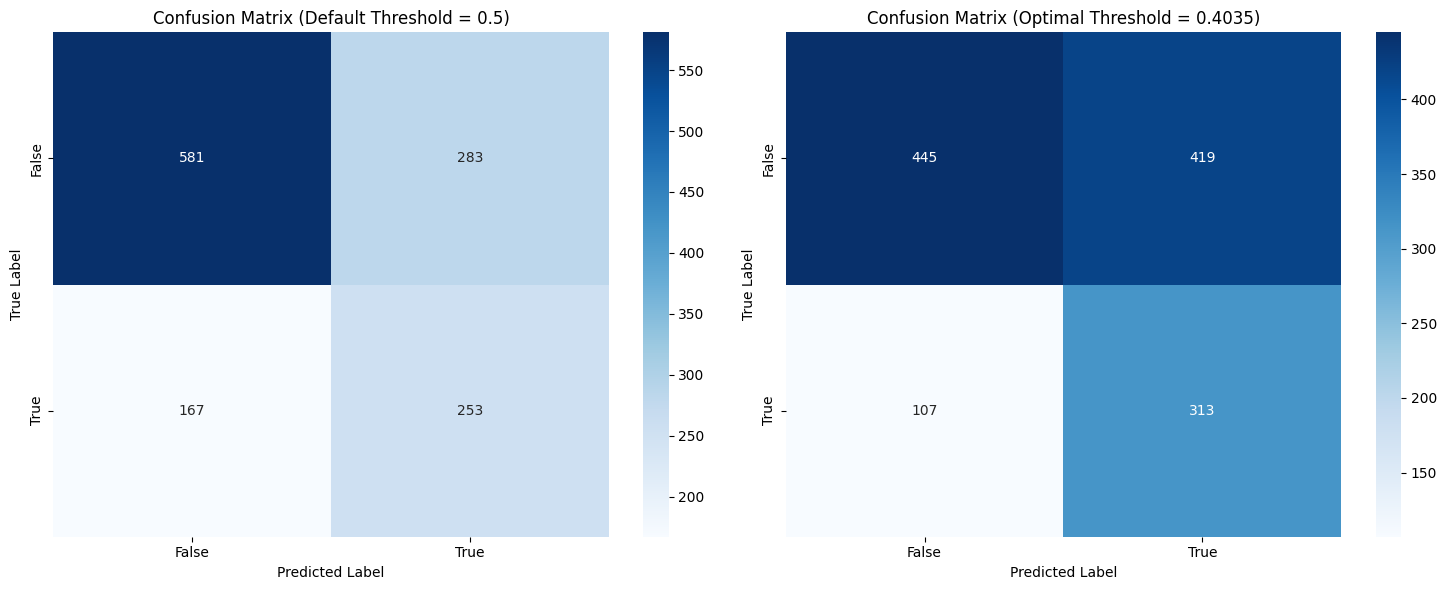

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrices
cm_default = confusion_matrix(y_valid, valid_preds_default)
cm_optimal = confusion_matrix(y_valid, valid_preds_optimal)

# Plot confusion matrices
plt.figure(figsize=(15, 6))

# Default threshold confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues',
           xticklabels=['False', 'True'],
           yticklabels=['False', 'True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Default Threshold = 0.5)')

# Optimal threshold confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
           xticklabels=['False', 'True'],
           yticklabels=['False', 'True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.4f})')

plt.tight_layout()
plt.savefig('deberta_confusion_matrices.png', dpi=300)
plt.show()

## 11. Evaluate on Test Set

In [20]:
# Make predictions on test set
test_outputs = model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
test_logits = test_outputs.logits
test_probs = tf.nn.sigmoid(test_logits).numpy().flatten()

# Predict with optimal threshold
test_preds_optimal = (test_probs >= optimal_threshold).astype(int)

# Predict with default threshold
test_preds_default = (test_probs >= 0.5).astype(int)

# Calculate metrics for optimal threshold
test_accuracy_optimal = np.mean(test_preds_optimal == y_test)
test_precision_optimal, test_recall_optimal, test_f1_optimal, _ = precision_recall_fscore_support(
    y_test, test_preds_optimal, average='binary'
)

# Calculate metrics for default threshold
test_accuracy_default = np.mean(test_preds_default == y_test)
test_precision_default, test_recall_default, test_f1_default, _ = precision_recall_fscore_support(
    y_test, test_preds_default, average='binary'
)

# Print results
print("\nTest Results (Default Threshold = 0.5):")
print(f"Accuracy: {test_accuracy_default:.4f}")
print(f"Precision: {test_precision_default:.4f}")
print(f"Recall: {test_recall_default:.4f}")
print(f"F1 Score: {test_f1_default:.4f}")
print("\nTest Classification Report (Default Threshold):")
print(classification_report(y_test, test_preds_default))

print("\nTest Results (Optimal Threshold = {:.4f}):".format(optimal_threshold))
print(f"Accuracy: {test_accuracy_optimal:.4f}")
print(f"Precision: {test_precision_optimal:.4f}")
print(f"Recall: {test_recall_optimal:.4f}")
print(f"F1 Score: {test_f1_optimal:.4f}")
print("\nTest Classification Report (Optimal Threshold):")
print(classification_report(y_test, test_preds_optimal))

40/40 [==============================] - 119s 3s/step

Test Results (Default Threshold = 0.5):
Accuracy: 0.6480
Precision: 0.5027
Recall: 0.6125
F1 Score: 0.5522

Test Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       818
           1       0.50      0.61      0.55       449

    accuracy                           0.65      1267
   macro avg       0.63      0.64      0.63      1267
weighted avg       0.67      0.65      0.65      1267


Test Results (Optimal Threshold = 0.4035):
Accuracy: 0.5856
Precision: 0.4497
Recall: 0.7572
F1 Score: 0.5643

Test Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       0.79      0.49      0.60       818
           1       0.45      0.76      0.56       449

    accuracy                           0.59      1267
   macro avg       0.62      0.62      0.58      1267
weighted avg       0.67      0

## 12. Calculate ROC AUC and Plot ROC Curve

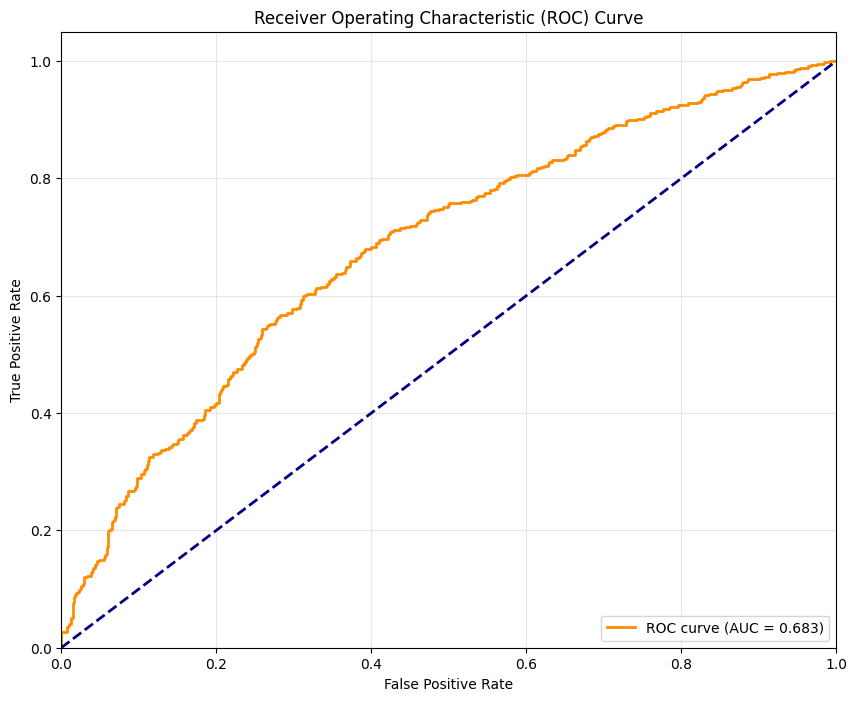

ROC AUC Score: 0.6832


In [21]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for test set
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('deberta_roc_curve.png', dpi=300)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

## 13. Compare with Baseline Model


Model Comparison (DeBERTa vs. Baseline):
   Metric  Baseline  DeBERTa Improvement
 Accuracy    0.5825 0.585635       0.31%
Precision    0.4315 0.449735       1.82%
   Recall    0.5612 0.757238      19.60%
 F1 Score    0.4879 0.564315       7.64%


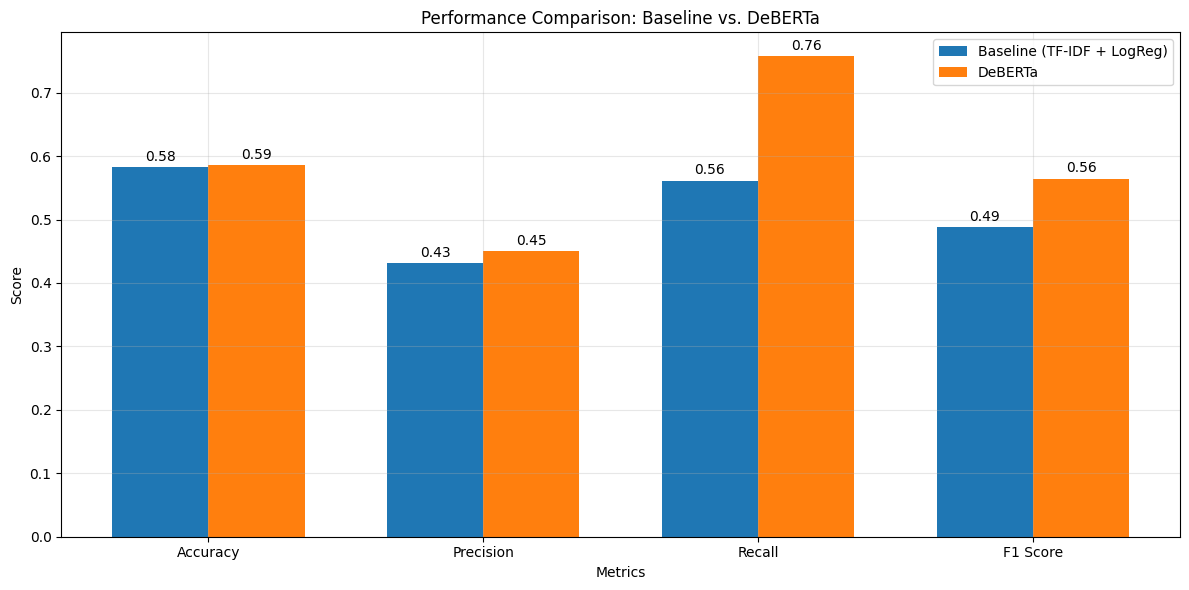

In [22]:
# Define baseline model metrics (from previous evaluation)
baseline_accuracy = 0.5825
baseline_f1 = 0.4879
baseline_precision = 0.4315
baseline_recall = 0.5612

# Calculate improvement
accuracy_improvement = test_accuracy_optimal - baseline_accuracy
f1_improvement = test_f1_optimal - baseline_f1
precision_improvement = test_precision_optimal - baseline_precision
recall_improvement = test_recall_optimal - baseline_recall

# Create comparison table
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Baseline': [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1],
    'DeBERTa': [test_accuracy_optimal, test_precision_optimal, test_recall_optimal, test_f1_optimal],
    'Improvement': [accuracy_improvement, precision_improvement, recall_improvement, f1_improvement]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df['Improvement'] = comparison_df['Improvement'].apply(lambda x: f"{x*100:.2f}%" if x >= 0 else f"{x*100:.2f}%")

# Print comparison
print("\nModel Comparison (DeBERTa vs. Baseline):")
print(comparison_df.to_string(index=False))

# Create bar chart for comparison
plt.figure(figsize=(12, 6))
metrics = comparison_data['Metric']
baseline_values = comparison_data['Baseline']
deberta_values = comparison_data['DeBERTa']

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, baseline_values, width, label='Baseline (TF-IDF + LogReg)')
plt.bar(x + width/2, deberta_values, width, label='DeBERTa')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison: Baseline vs. DeBERTa')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(baseline_values):
    plt.text(i - width/2, v + 0.01, f"{v:.2f}", ha='center')
    
for i, v in enumerate(deberta_values):
    plt.text(i + width/2, v + 0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()